In [1]:
import os
import csv
import numpy as np
import pandas as pd
import gensim
import pickle
import re
import string
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from joblib import dump, load
import seaborn as sns

In [2]:
df = pd.read_csv("30k_article.tsv", delimiter='\t', encoding='utf-8', names=['title', 'summary', 'content', 'writtenTime', 'url', 'category', 'tag', 'source'], error_bad_lines=False)
df = df.dropna(subset=['title', 'summary', 'content'])
df.head(5)

,title,summary,content,writtenTime,url,category,tag,source
0,"Văn Hậu sang Hà Lan rạng sáng mai, sắp khoác á...",Đoàn Văn Hậu đã được cấp visa lao động và sẽ l...,"Sau cuộc làm việc với Đại sứ quán Hà Lan, cùng...",16/09/19 17:38 GMT+7,https://baomoi.com/c/32211905.epi,Thể thao,SC Heerenveen Đoàn Văn Hậu Văn Hậu Hà lan Sở D...,Zing
1,Cô giáo liên tục mất ngủ sau tai nạn giao thôn...,"Tại bệnh viện, sức khỏe của cô giáo không may ...",Cô giáo chạy xe 130 km đi dạy không may bị tai...,16/09/19 17:39 GMT+7,https://baomoi.com/c/32211906.epi,Pháp luật,Trần Thị Bá Tiền Đắk H’lơ Bệnh viện Quân Y 211...,Zing
2,Chuẩn bị đấu thầu xây lắp dự án nâng cấp QL25,Dự án nâng cấp QL25 sẽ được đấu thầu xây lắp t...,Một đoạn tuyến QL25 qua địa phận tỉnh Gia Lai ...,16/09/19 17:37 GMT+7,https://baomoi.com/c/32211909.epi,Xã hội,Ban QLDA 6 QL25 Chư Sê Sở GTVT tỉnh Phú Yên Sở...,Giao Thông
3,"Sĩ Thanh hay khoe make up, dưỡng da bằng sản p...","Trước khi gây chú ý với màn đập hộp hàng hiệu,...","Ngày 8/9, Sĩ Thanh lần đầu đăng tải clip đập h...",16/09/19 16:53 GMT+7,https://baomoi.com/c/32211910.epi,Đời sống,FAKE Đập hộp Sĩ Thanh Louis Vuitton Hàng hiệu ...,Em Đẹp
4,Cô giáo chạy xe 130 km đi dạy không may bị tai...,'Tôi muốn ngủ một lúc cho quên đi cánh tay đau...,Theo Người Lao Động,16/09/19 17:39 GMT+7,https://baomoi.com/c/32211912.epi,Đời sống,Cánh tay Đầu óc Cô giáo Quên đi Tai nạn giao t...,Zing


In [3]:
from collections import Counter
print("Total: ", len(df.index))
Counter(df["category"])

Total:  29307


Counter({'Thể thao': 2349,
         'Pháp luật': 5580,
         'Xã hội': 3475,
         'Đời sống': 2245,
         'Xe cộ': 494,
         'Công nghệ': 1344,
         'Giải trí': 3108,
         'Nhà đất': 1446,
         'Giáo dục': 1073,
         'Kinh tế': 3363,
         'Khoa học': 660,
         'Thế giới': 2677,
         'Văn hóa': 1493})

In [4]:
df["data"] = df["title"] + ' ' + df["summary"] + ' ' + df["content"]

In [5]:
data = df[['data','category']].copy()
data.head(5)

,data,category
0,"Văn Hậu sang Hà Lan rạng sáng mai, sắp khoác á...",Thể thao
1,Cô giáo liên tục mất ngủ sau tai nạn giao thôn...,Pháp luật
2,Chuẩn bị đấu thầu xây lắp dự án nâng cấp QL25 ...,Xã hội
3,"Sĩ Thanh hay khoe make up, dưỡng da bằng sản p...",Đời sống
4,Cô giáo chạy xe 130 km đi dạy không may bị tai...,Đời sống


In [6]:
def preprocess(s):
    for ch in string.punctuation:                                                                                                     
        s = s.replace(ch, " ") 
    s = s.replace(ch, "'") 
    s = re.sub("\s\s+", " ", s)
    s = re.sub("\s\d+(?=\s)", "", s)
    s = re.sub("\s\d{1,2}h\d{1,2}", "", s) #remove time
    s = s.lower()
    return s

In [7]:
text = 'Văn Hậu sang Hà Lan rạng sáng mai, sắp khoác áo 17h15 Heerenveen'

In [8]:
print(preprocess(text))

văn hậu sang hà lan rạng sáng mai sắp khoác áo heerenveen


In [9]:
data.loc[:,'data'] = data.data.apply(lambda s: preprocess(s))

In [10]:
data.head()

,data,category
0,văn hậu sang hà lan rạng sáng mai sắp khoác áo...,Thể thao
1,cô giáo liên tục mất ngủ sau tai nạn giao thôn...,Pháp luật
2,chuẩn bị đấu thầu xây lắp dự án nâng cấp ql25 ...,Xã hội
3,sĩ thanh hay khoe make up dưỡng da bằng sản ph...,Đời sống
4,cô giáo chạy xe km đi dạy không may bị tai nạn...,Đời sống


In [11]:
data.loc[[0]].values

array([['văn hậu sang hà lan rạng sáng mai sắp khoác áo heerenveen đoàn văn hậu đã được cấp visa lao động và sẽ lên đường sang hà lan vào rạng sáng để chuẩn bị thi đấu trong màu áo sc heerenveen sau cuộc làm việc với đại sứ quán hà lan cùng việc có thư đảm bảo từ sở di trú hà lan về hợp đồng lao động đoàn văn hậu đã được cấp visa và sẽ lên đường hội quân cùng sc heerenveen theo kế hoạch chuyến bay của đoàn văn hậu cất cánh lúc ngày hậu vệ quê thái bình đã chia tay đồng đội và lãnh đạo clb hà nội sau ít ngày ở lại việt nam chờ thủ tục thi đấu ngay khi hội quân cầu thủ này sẽ bước vào tập luyện cùng đồng đội mới ở heerenveen văn hậu có thể ra sân chơi cho heerenveen ngay trong tuần này ảnh sc heerenveen phía sc heerenveen cũng chuẩn bị hoàn tất khâu hậu cần để văn hậu có thể ra sân ngay trong tuần này nếu đảm bảo yêu cầu về chuyên môn đội bóng mới của hậu vệ sinh năm sẽ tiếp đón fc utrecht lúc ngày giờ việt nam cầu thủ tuổi ra mắt đội bóng của hà lan hôm anh được clb hà nội chuyển nhượng

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.category, train_size = 0.8 , random_state = 42)

In [13]:
pickle.dump(X_train, open('./datasets/preprocess/X_train.pkl', 'wb'))
pickle.dump(y_train, open('./datasets/preprocess/y_train.pkl', 'wb'))
pickle.dump(X_test, open('./datasets/preprocess/X_test.pkl', 'wb'))
pickle.dump(y_test, open('./datasets/preprocess/y_test.pkl', 'wb'))

In [14]:
X_train = pickle.load(open('./datasets/preprocess/X_train.pkl', 'rb'))
y_train = pickle.load(open('./datasets/preprocess/y_train.pkl', 'rb'))
X_test = pickle.load(open('./datasets/preprocess/X_test.pkl', 'rb'))
y_test = pickle.load(open('./datasets/preprocess/y_test.pkl', 'rb'))

In [15]:
model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2), lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced", random_state=42)))])

In [16]:
%%time
model.fit(X_train, y_train)

Wall time: 1min 22s


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabul...ne)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight='balanced',
   

In [17]:
model.classes_

array(['Công nghệ', 'Giáo dục', 'Giải trí', 'Khoa học', 'Kinh tế',
       'Nhà đất', 'Pháp luật', 'Thế giới', 'Thể thao', 'Văn hóa', 'Xe cộ',
       'Xã hội', 'Đời sống'], dtype='<U9')

In [18]:
%%time
y_pred = model.predict(X_test)

Wall time: 7.46 s


In [19]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 207,    4,    2,    1,   13,    2,    6,   14,    0,    0,    0,
           8,    4],
       [   2,  170,    5,    1,    2,    0,    9,    4,    3,    3,    0,
           5,    1],
       [   0,    4,  572,    0,    1,    0,    5,    4,    1,   16,    0,
           0,    6],
       [   2,    0,    2,   93,    0,    0,    4,    1,    1,    4,    0,
           1,    7],
       [  17,    8,    0,    0,  577,   10,    9,   11,    0,    7,    2,
          39,    3],
       [   2,    4,    0,    1,    8,  211,    7,    2,    0,    9,    1,
          13,    5],
       [   9,    5,    6,   11,   13,   16, 1000,   14,    1,    2,    0,
          31,   13],
       [   6,    0,    0,    4,   14,    0,   10,  526,    0,    3,    0,
           6,    2],
       [   0,    3,    2,    1,    0,    0,    0,    1,  450,    2,    0,
           1,    2],
       [   1,    8,   15,    5,    6,    3,    2,    4,    2,  258,    0,
           8,    7],
       [   2,    0,    0,    0,    2,    0,    0, 

In [20]:
df_cm = pd.DataFrame(index=model.classes_, data=cm)
df_cm.to_csv('cm.csv', index=True, header=model.classes_)

In [21]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [22]:
print("{0:30} {1:15} {2:1}".format("Label", "Precision", "Recall"))
for i in range(13):
    print("{0:30} {1:5.3} {2:15.3}".format(model.classes_[i], precision(i, cm), recall(i, cm)))
print("Precision total:", precision_macro_average(cm))
print("Recall total:", recall_macro_average(cm))

Label                          Precision       Recall
Công nghệ                      0.796           0.793
Giáo dục                       0.776           0.829
Giải trí                       0.918           0.939
Khoa học                       0.732           0.809
Kinh tế                        0.866           0.845
Nhà đất                        0.821           0.802
Pháp luật                      0.918           0.892
Thế giới                       0.898           0.921
Thể thao                       0.983           0.974
Văn hóa                        0.809           0.809
Xe cộ                          0.939           0.947
Xã hội                          0.83            0.84
Đời sống                       0.873           0.865
Precision total: 0.8584641912018982
Recall total: 0.866618870922819


In [29]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(12,10), fontsize=10):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig("cm.png") 
#     return fig

def cm_analysis(confusion_matrix, class_names, figsize=(20,18), fontsize=10):
    cm_sum = np.sum(confusion_matrix, axis=1, keepdims=True)
    cm_perc = confusion_matrix / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion_matrix).astype(str)
    nrows, ncols = confusion_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = confusion_matrix[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("cm_percent.png")

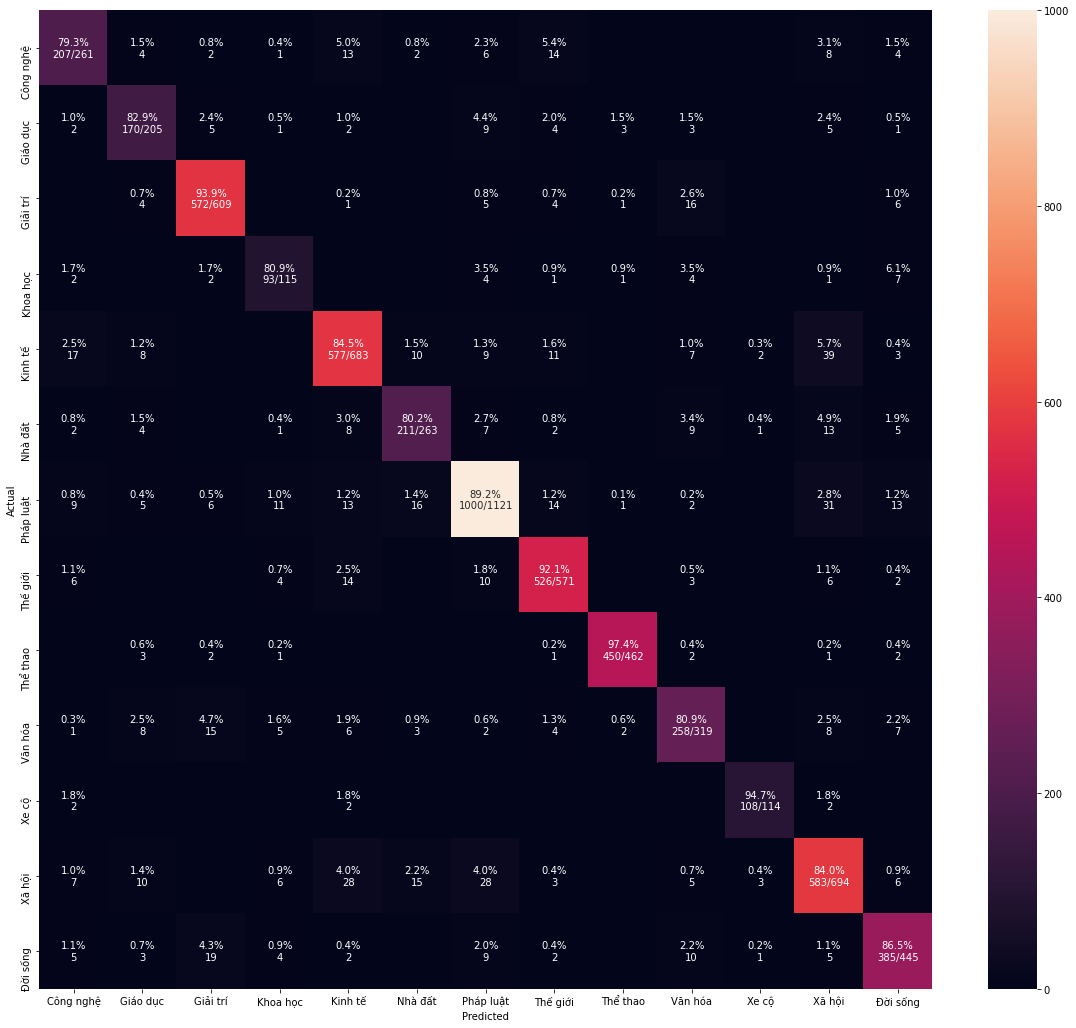

In [30]:
cm_analysis(cm, model.classes_)

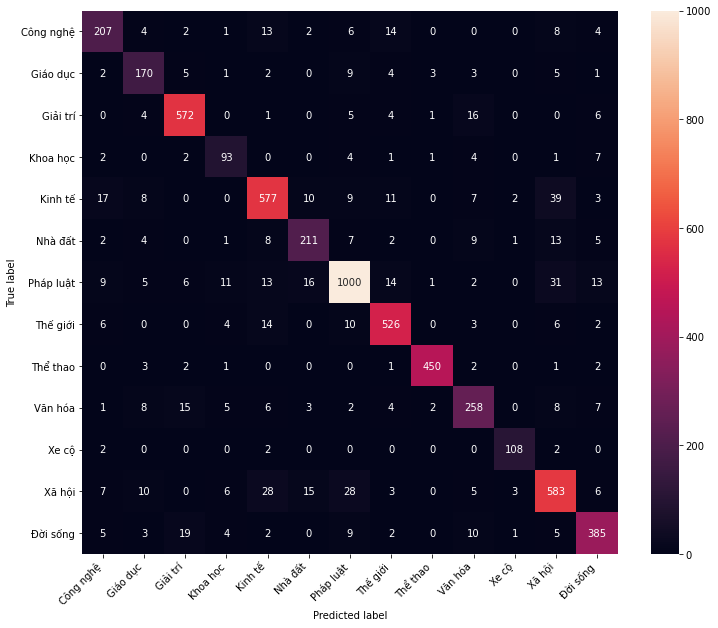

In [25]:
print_confusion_matrix(cm, model.classes_)

In [26]:
%%time
dump(model, 'liblinear.pkl')

Wall time: 38.8 s


['liblinear.pkl']

In [27]:
%%time
loaded_model = load('liblinear.pkl') 

Wall time: 15.3 s


In [28]:
inp = input()
print("**{}**".format(loaded_model.predict([inp])[0]))

**Xã hội**
